# Initialization

## Import of useful modules:

In [1]:
%matplotlib inline
import os, sys
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
from tqdm.notebook import tqdm

from time import sleep, monotonic, time


import qcodes as qc
from qcodes import Parameter
from qcodes.dataset.plotting import plot_dataset, plot_by_id
from qcodes.utils.metadata import diff_param_values
from qcodes.instrument.specialized_parameters import ElapsedTimeParameter
from qcodes.dataset.measurements import Measurement

sys.path.append('M:\\tnw\\ns\\qt\\2D Topo\\code\\qcodes')
from sweeps import do1d, do2d, time_sweep, measure_until, do1d_until

import warnings
warnings.filterwarnings('ignore')

Next we initializee the instruments. Note that you need to provide the correct fridge name!

To modify list of instruments, go to the folder
"2D Topo\code\fridge_specific"

In [2]:
fridge_name = 'Gecko'
%run ..\..\..\..\..\code\qcodes\init_fridge.py {fridge_name}

Connected to: KEITHLEY INSTRUMENTS INC. 2000 (serial:1330543, firmware:A20  /A02) in 0.19s


[keithley_1(Keithley_2000)] Snapshot: Could not update parameter: trigger_count


Connected to: KEITHLEY INSTRUMENTS INC. 2000 (serial:4107614, firmware:B01  /A02) in 0.12s


[keithley_2(Keithley_2000)] Snapshot: Could not update parameter: trigger_count


Connected to: Stanford_Research_Systems SR830 (serial:s/n47557, firmware:ver1.07) in 0.10s
Connected to: Stanford_Research_Systems SR830 (serial:s/n43309, firmware:ver1.07) in 0.07s
Connected to: LSCI 332S (serial:332557, firmware:112002) in 0.21s
Initialized IVVI-rack in 0.05s


Here are all the instruments we have:

In [3]:
station.components

{'keithley_1': <Keithley_2000: keithley_1>,
 'keithley_2': <Keithley_2000: keithley_2>,
 'lockin_1': <SR830: lockin_1>,
 'lockin_2': <SR830: lockin_2>,
 'lakeshore': <Model_332: lakeshore>,
 'ivvi': <IVVI: ivvi>}

Zero dacs and lockin

In [105]:
ivvi.set_dacs_zero()
lockin_1.amplitude(0.004)
lockin_2.amplitude(0.004)

Change the dac rate (same idea as with qtlab, but two commands are used)

## DAC rates

In [5]:
ivvi.dac1.step = 50
ivvi.dac1.inter_delay = 0.05
ivvi.dac2.step = 50
ivvi.dac2.inter_delay = 0.05
ivvi.dac3.step = 1
ivvi.dac3.inter_delay = 0.05

## Database initialisation

Next, we create a qcodes database. If you want to use an existing one, set reuse 'True'. Database is created in the "data" folder. Sample folder is the same as for this script

In [6]:
reuse = True
%run ..\..\..\..\..\code\qcodes\init_database.py {reuse}

Creating a new database file:
M:\tnw\ns\qt\2D Topo\samples\InSbAs_epiAl\M06-18-19.1\33\data\M06-18-19.1_33_2021-02-18_01.db
Upgrading database; v0 -> v1: : 0it [00:00, ?it/s]
Upgrading database; v1 -> v2:
Upgrading database; v2 -> v3: : 0it [00:00, ?it/s]
Upgrading database; v3 -> v4: : 0it [00:00, ?it/s]
Upgrading database; v4 -> v5:
Upgrading database; v5 -> v6: : 0it [00:00, ?it/s]
Upgrading database; v6 -> v7:
Upgrading database; v7 -> v8:
Upgrading database; v8 -> v9:


# Scaled parameters

It is more convenient to use meaningful parameters with correct units

In [7]:
from qcodes import ManualParameter, ScaledParameter

## Defining scaled parameters

In [8]:
Irange = Parameter('Irange', label='current range', unit='', set_cmd=None, get_cmd=None)
Vrange = Parameter('Vrange', label='voltage range', unit='', set_cmd=None, get_cmd=None)
TGrange = Parameter('TGrange', label='Top gate range', unit='', set_cmd=None, get_cmd=None)

#division paraemtrs required for simplier update: they used as an argument for scaled paraemtrs of sorce instruments

Irange_division = Parameter('Irange_division', 
                            label='scaled current range', unit='', 
                            set_cmd=None, get_cmd=lambda : 1000 / Irange())

Vrange_division = Parameter('Vrange_division', 
                            label='scaled voltage range', unit='', 
                            set_cmd=None, get_cmd=lambda : 1000 / Vrange())

TGrange_division = Parameter('TGrange_division', 
                             label='scaled Top gate range', unit='', 
                             set_cmd=None, get_cmd=lambda : 1000 / TGrange())

Irange_AC_division = Parameter('Irange_AC_division', 
                               label='scaled current range for lockin', unit='', 
                               set_cmd=None, get_cmd=lambda : 100 / Irange())

Vrange_AC_division = Parameter('Vrange_AC_division', 
                               label='scaled voltage range for lockin', unit='', 
                               set_cmd=None, get_cmd=lambda : 100 / Vrange())

Gain_K1 = Parameter('Gain_K1', label='Gain K1', unit='', set_cmd=None, get_cmd=None)
Gain_K2 = Parameter('Gain_K2', label='Gain K2', unit='', set_cmd=None, get_cmd=None)
Gain_L1 = Parameter('Gain_L1', label='Gain L1', unit='', set_cmd=None, get_cmd=None)
Gain_L2 = Parameter('Gain_L2', label='Gain L2', unit='', set_cmd=None, get_cmd=None)

#Add components
station.add_component(Irange)
station.add_component(Vrange)
station.add_component(TGrange)

station.add_component(Irange_division)
station.add_component(Vrange_division)
station.add_component(TGrange_division)

station.add_component(Irange_AC_division)
station.add_component(Vrange_AC_division)
                             
station.add_component(Gain_K1)
station.add_component(Gain_K2)
station.add_component(Gain_L1)
station.add_component(Gain_L2)

'Gain_L2'

## IVVI rack parameters - update here during measuerements

Also can be coppied to execute later

In [43]:
Irange.set(10e-6)
Vrange.set(10e-3) 
TGrange.set(15)
Gain_K1.set(1e2)
Gain_K2.set(1e6)
# Gain_K3.set(1e2)
Gain_L1.set(Gain_K1())
Gain_L2.set(Gain_K2())

#division parameters are updated automatically

## DC parameters - assigning devices
Check that devicies are correct!

In [10]:
appl_current = ScaledParameter(ivvi.dac1, division = Irange_division, name = 'appl_current', unit = 'A')
appl_voltage = ScaledParameter(ivvi.dac2, division = Vrange_division, name = 'appl_voltage', unit = 'V')
appl_TG = ScaledParameter(ivvi.dac3, division = TGrange_division, name = 'appl_TG', unit = 'V')

meas_voltage_K1 = ScaledParameter(keithley_1.amplitude, division = Gain_K1, name = 'meas_voltage_K1', unit = 'V')
meas_voltage_K2 = ScaledParameter(keithley_2.amplitude, division = Gain_K2, name = 'meas_voltage_K2', unit = 'V')
# meas_voltage_K3 = ScaledParameter(keithley_3.amplitude, division = Gain_K3, name = 'meas_voltage_K3', unit = 'V')
meas_leakage = ScaledParameter(keithley_2.amplitude, division = Gain_K2, name = 'meas_leakage', unit = 'A')

meas_current_K1 = ScaledParameter(keithley_1.amplitude, division = Gain_K1, name = 'meas_current_K1', unit = 'A')
meas_current_K2 = ScaledParameter(keithley_2.amplitude, division = Gain_K2, name = 'meas_current_K2', unit = 'A')
# meas_current_K3 = ScaledParameter(keithley_3.amplitude, division = Gain_K3, name = 'meas_current_K3', unit = 'A')

station.add_component(appl_current)
station.add_component(appl_voltage)
station.add_component(appl_TG)
station.add_component(meas_voltage_K1)
station.add_component(meas_voltage_K2)
# station.add_component(meas_voltage_K3)
station.add_component(meas_leakage)
station.add_component(meas_current_K1)
station.add_component(meas_current_K2)
# station.add_component(meas_current_K3)

'meas_current_K2'

## AC parameters

In [11]:
appl_current_AC = ScaledParameter(lockin_1.amplitude, division = Irange_AC_division, name = 'appl_current_AC', unit = 'A')
# appl_current_AC_2 = ScaledParameter(lockin_2.amplitude, division = Irange_2_AC_division, name = 'appl_current_2_AC', unit = 'A')

appl_voltage_AC = ScaledParameter(lockin_1.amplitude, division = Vrange_AC_division, name = 'appl_voltage_AC', unit = 'V')

station.add_component(appl_current_AC)
# station.add_component(appl_current_AC_2)
station.add_component(appl_voltage_AC)

meas_voltage_AC_L1 = ScaledParameter(lockin_1.X, division = Gain_L1, name = 'meas_voltage_Lockin1', unit = 'V')
meas_voltage_AC_L2 = ScaledParameter(lockin_2.X, division = Gain_L2, name = 'meas_voltage_Lockin2', unit = 'V')

meas_current_AC_L1 = ScaledParameter(lockin_1.X, division = Gain_L1, name = 'meas_current_Lockin1', unit = 'A')
meas_current_AC_L2 = ScaledParameter(lockin_2.X, division = Gain_L2, name = 'meas_current_Lockin2', unit = 'A')

station.add_component(meas_voltage_AC_L1)
station.add_component(meas_voltage_AC_L2)
station.add_component(meas_current_AC_L1)
station.add_component(meas_current_AC_L2)

'meas_current_Lockin2'

### Also might be important to store lokin R!

In [12]:
meas_voltage_AC_L1_R = ScaledParameter(lockin_1.R, division = Gain_L1, name = 'meas_voltage_R_Lockin1', unit = 'V')
meas_voltage_AC_L2_R = ScaledParameter(lockin_2.R, division = Gain_L2, name = 'meas_voltage_R_Lockin2', unit = 'V')

station.add_component(meas_voltage_AC_L1_R)
station.add_component(meas_voltage_AC_L2_R)

'meas_voltage_R_Lockin2'

# Extract R

In [13]:
def get_R_from_IV(dataid):
    dataset = qc.load_by_id(dataid)

    voltage = dataset.get_parameter_data()['meas_voltage_K1']['meas_voltage_K1']
    current = dataset.get_parameter_data()['meas_voltage_K1']['appl_current']
    fit_values = np.polyfit(current,voltage,1)
    
    return fit_values[0]

# Segment length

In [14]:
Segment_length = Parameter('Segment_length', label='Segment_length', unit='um', set_cmd=None, get_cmd=None)
station.add_component(Segment_length)

'Segment_length'

In [15]:
Segment_length(12)

In [ ]:
Segment_length()

# Gate sweeps

In [22]:
appl_TG(0.0)

In [34]:
exp = qc.new_experiment('I_vs_Vtg', sample_name='TL')

appl_voltage(1e-3)

start_gate = -1
stop_gate = -2.5
num_points = 300
leak_threshold = 1e-9

#Register independent parameters
meas = Measurement()
meas.register_parameter(appl_TG)
appl_TG.post_delay = 0.05

#Register dependent parametrs
param_meas = [meas_current_K1, meas_leakage]
output = []
for parameter in param_meas:
    meas.register_parameter(parameter, setpoints=(appl_TG,)) #dependend parameters
    output.append([parameter, None])

#Add action at the end
meas.add_after_run(ivvi.set_dacs_zero, ())

appl_TG(start_gate)
sleep(2)

#Start measuremnts
with meas.run() as datasaver:
    for set_point in tqdm(np.linspace(start_gate, stop_gate, num_points)): #for progress
        appl_TG(set_point)
        sleep(0.05)
        if np.abs(meas_leakage()) > leak_threshold:
            print('Leakage detected!')
            break
        sleep(0.05)
        for i, parameter in enumerate(param_meas):
            output[i][1] = parameter.get()
        datasaver.add_result((appl_TG, appl_TG()),
                             *output)
dataid = datasaver.run_id  # convenient to have for plotting

Starting experimental run with id: 10. 


  0%|          | 0/300 [00:00<?, ?it/s]

([<AxesSubplot:title={'center':'Run #10, Experiment I_vs_Vtg (TL)'}, xlabel='appl_TG (V)', ylabel='meas_current_K1 (pA)'>,
  <AxesSubplot:title={'center':'Run #10, Experiment I_vs_Vtg (TL)'}, xlabel='appl_TG (V)', ylabel='meas_leakage (pA)'>],
 [None, None])

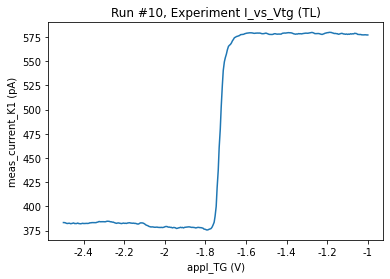

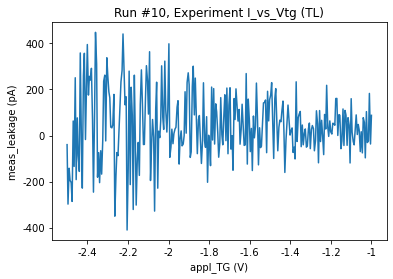

In [35]:
plot_by_id(dataid)

In [38]:
appl_voltage(1e-3)
appl_TG(0.5)
sleep(2)
station.snapshot(update=True);
exp = qc.new_experiment('I_vs_Vgate_down', sample_name='TL')
dataid1 = do1d(appl_TG, 0.5, -2, 600, 0.1, meas_current_K1)
# plot_by_id(dataid1)

# station.snapshot(update=True);
exp = qc.new_experiment('I_vs_Vgate_down', sample_name='TL')
dataid2 = do1d(appl_TG, -2, 0.5, 600, 0.1, meas_current_K1)
# plot_by_id(dataid2)

ivvi.set_dacs_zero()

[keithley_1(Keithley_2000)] Snapshot: Could not update parameter: trigger_count
[keithley_2(Keithley_2000)] Snapshot: Could not update parameter: trigger_count


Starting experimental run with id: 13. 


  0%|          | 0/600 [00:00<?, ?it/s]

Starting experimental run with id: 14. 


  0%|          | 0/600 [00:00<?, ?it/s]

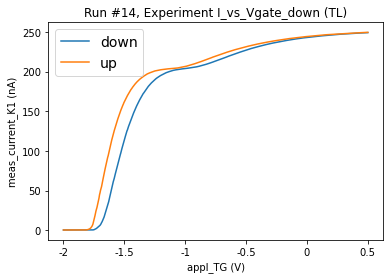

In [39]:
fig, ax = plt.subplots(1)
axes, cbaxes = plot_by_id(dataid1, axes=[ax], label = 'down')
axes, cbaxes = plot_by_id(dataid2, axes=[ax], label = 'up')
plt.legend(fontsize = 14)
plt.savefig('../plots/TL_16um_hyst1.png')

In [ ]:
ivvi.set_dacs_zero()

## Lockin gate sweeps

In [ ]:
appl_TG(0)

In [ ]:
appl_current_AC(100e-9)

In [ ]:
meas_voltage_AC_L1()/appl_current_AC()

In [78]:
Segment_length(28)

In [79]:
appl_TG(-1.3)
appl_current_AC(100e-9)
sleep(2)
station.snapshot(update=True);
exp = qc.new_experiment('Vac_vs_Vgate', sample_name='TL')
dataid1 = do1d(appl_TG, -1.3, 0.5, 151, 0.5, meas_voltage_AC_L1)
ivvi.set_dacs_zero()
appl_TG(0)

[keithley_1(Keithley_2000)] Snapshot: Could not update parameter: trigger_count
[keithley_2(Keithley_2000)] Snapshot: Could not update parameter: trigger_count


Starting experimental run with id: 31. 


  0%|          | 0/151 [00:00<?, ?it/s]

In [42]:
ivvi.set_dacs_zero()
appl_TG(0)

In [ ]:
plot_by_id(dataid1)

In [ ]:
dataset = qc.load_by_id(19)
dataset.snapshot['station']['parameters']['Segment_length']['value']

# IVs for TLMs

## 1D sweeps

In [40]:
ivvi.set_dacs_zero()

In [41]:
appl_TG(0)

In [55]:
Segment_length(3)

[keithley_1(Keithley_2000)] Snapshot: Could not update parameter: trigger_count
[keithley_2(Keithley_2000)] Snapshot: Could not update parameter: trigger_count


Starting experimental run with id: 22. 


  0%|          | 0/101 [00:00<?, ?it/s]

99.99842027570466

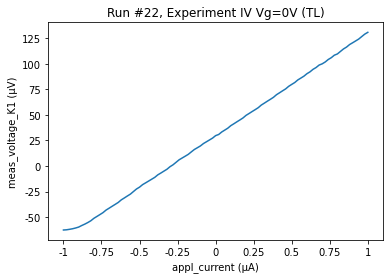

In [56]:
appl_current(-1e-6)
sleep(2)
station.snapshot(update=True);
exp = qc.new_experiment('IV Vg=0V', sample_name='TL')
dataid = do1d(appl_current, -1e-6, 1e-6, 101, 0.05, meas_voltage_K1)

# ivvi.set_dacs_zero()
appl_current(0)

plot_by_id(dataid)
get_R_from_IV(dataid)

In [ ]:
appl_current_AC(100e-9)

In [ ]:
meas_voltage_AC_L1()/appl_current_AC()

In [ ]:
#Mark: gate dependence of Tc
#start_gate = -0.1
#stop_gate = 0.5
#num_points = 6
#for set_point in tqdm(np.linspace(start_gate, stop_gate, num_points)): #for progress
    #appl_TG(set_point)
    #sleep(0.05)
    #appl_current(-1e-6)
    #sleep(1)
    #station.snapshot(update=True);
    #exp = qc.new_experiment('IV {}'.format(set_point), sample_name='BR')
    #dataid = do1d(appl_current, -1e-6, 1e-6, 101, 0.05, meas_voltage_K1)

    # ivvi.set_dacs_zero()
    #appl_current(0)

    #plot_by_id(dataid)
    
   # get_R_from_IV(dataid)

In [57]:
lenghts = np.array([28/2,12,9,9,6,6,3])
r_s = np.array([681/2, 299, 235, 233, 162, 159, 99])

In [58]:
fit_vals = np.polyfit(lenghts, r_s, 1)

In [59]:
fit_vals

array([22.34583333, 29.87083333])

In [60]:
x_vals = np.linspace(0,13, 10)

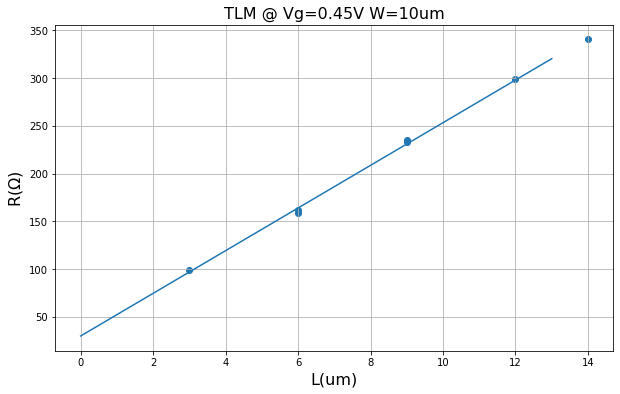

In [61]:
fig, ax = plt.subplots(1, figsize = (10,6))

ax.scatter(lenghts, r_s)

ax.plot(x_vals, x_vals * fit_vals[0] + fit_vals[1])

ax.set_xlabel('L(um)', fontsize = 16)
ax.set_ylabel(r'R($\Omega$)', fontsize = 16)
plt.title('TLM @ Vg=0.45V W=10um', fontsize = 16)
plt.grid(True)

plt.savefig('../plots/R_vs_L_Vg0.45V.png')

# Analysis

In [80]:
import scipy

In [81]:
from scipy.stats import linregress
from scipy.stats import t

In [82]:
#inverse Student T distribution
tinv = lambda p, df: abs(t.ppf(p/2, df))

In [95]:
dataset_ids = np.array([26, 27, 28, 29, 30]) #dataset IDs of Vac vs Vgate

In [96]:
dataset_ids

array([26, 27, 28, 29, 30])

In [97]:
#quantile of the T distribution:
ts = tinv(0.05, len(dataset_ids)-2)

In [98]:
#extract Vgate array from any scan, for example first
dataset = qc.load_by_id(dataset_ids[0])
vgate = dataset.get_parameter_data()['meas_voltage_Lockin1']['appl_TG']

#current AC is fixed during the sweep
current_AC = dataset.snapshot['station']['parameters']['appl_current_AC']['value']

#R of 2DEG
Rs_sq = np.zeros_like(vgate)
Rs_sq_95percent_interval = np.zeros_like(vgate)
#Rcontact, same size array as vgate
Rs_contact = np.zeros_like(vgate)

Rs_contact_95percent_interval = np.zeros_like(vgate)

all_Rs = np.zeros( (np.size(vgate),np.size(dataset_ids)) )
lengths = np.zeros_like(dataset_ids)

In [99]:
all_Rs.shape

(151, 5)

In [100]:
for idx, dataid in enumerate(dataset_ids):
    dataset = qc.load_by_id(dataid)
    length = dataset.snapshot['station']['parameters']['Segment_length']['value']
    print(length)
    v_ac = dataset.get_parameter_data()['meas_voltage_Lockin1']['meas_voltage_Lockin1']
    all_Rs[:,idx] = np.abs(v_ac/current_AC)
    lengths[idx] = length

6
6
9
9
12


In [101]:
for gate_idx,val in enumerate(vgate):
    resistances_to_fit = all_Rs[gate_idx]
    result = linregress(lengths, resistances_to_fit)
    
    R_sq = 10 * result.slope #width 10um
    R_contact = result.intercept / 2 * 10 #2 contacts, 10um wide
    
    Rs_sq[gate_idx] = R_sq
    Rs_contact[gate_idx] = R_contact
    
    
    slope_95_interval = ts*result.stderr
    intercept_95_interval = ts*result.intercept_stderr
        
    Rs_sq_95percent_interval[gate_idx] = slope_95_interval * 10
    Rs_contact_95percent_interval = intercept_95_interval / 2 * 10

-0.34


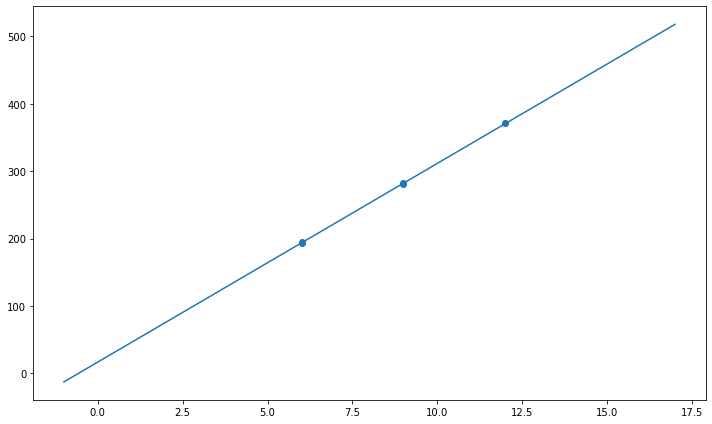

In [102]:
fig, ax = plt.subplots(1, figsize = (10,6), tight_layout = True)

gate_id = 80
ax.scatter(lengths, all_Rs[gate_id,:])

print(vgate[gate_id])

x_vals = np.linspace(-1,17)
ax.plot(x_vals, x_vals*Rs_sq[gate_id]/10 + Rs_contact[gate_id]*2/10)

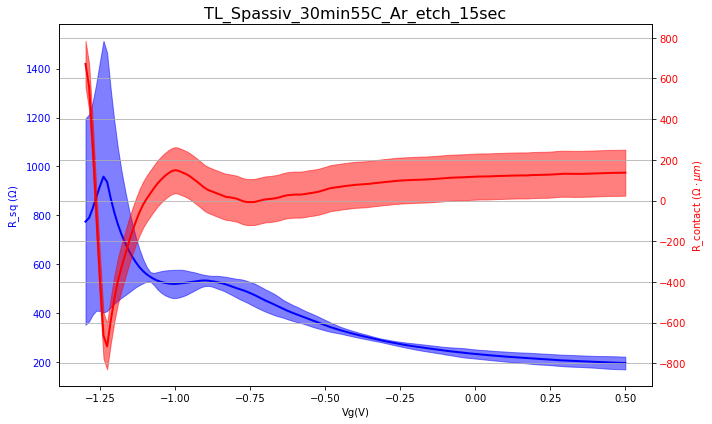

In [104]:
fig, ax = plt.subplots(1, figsize = (10,6), tight_layout = True)
ax2 = ax.twinx()

ax.plot(vgate, Rs_sq, label = 'R_sq', linewidth = 2, color = 'blue')
ax2.plot(vgate, Rs_contact, label = 'R_contact', linewidth = 2, color = 'red')

ax2.set_ylabel(r'R_contact ($\Omega \cdot \mu m $)', color = 'red')  # we already handled the x-label with ax1
ax2.tick_params(axis='y',  labelcolor = 'red')

ax.set_ylabel(r'R_sq ($\Omega$)', color = 'blue')  # we already handled the x-label with ax1
ax.tick_params(axis='y',  labelcolor = 'blue')

ax2.fill_between(vgate, 
                Rs_contact - Rs_contact_95percent_interval, Rs_contact + Rs_contact_95percent_interval,
                color = 'red', alpha = 0.5)

ax.fill_between(vgate, 
                Rs_sq - Rs_sq_95percent_interval, Rs_sq + Rs_sq_95percent_interval,
                color = 'blue', alpha = 0.5)
# ax.legend(fontsize = 16)
# ax.set_xlim(0.25, 0.45)
# ax.set_ylim(2500, 7500)
# ax2.set_ylim(5000, 15000)

ax2.grid()
ax.set_xlabel('Vg(V)')
# ax.set_ylabel(r'R($\Omega$)')
plt.title('TL_Spassiv_30min55C_Ar_etch_15sec', fontsize = 16)
plt.savefig('../plots/Rs_vs_gates_TL.png')